# Create Data

In [1]:
import random
import numpy as np
import pandas as pd
from scipy.stats.stats import spearmanr
import matplotlib.pyplot as plt

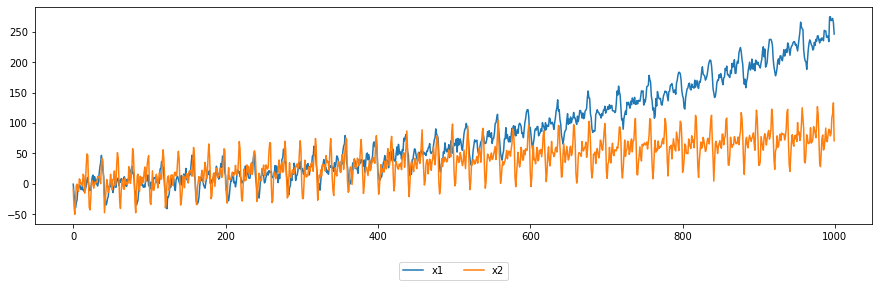

In [2]:
n_ = 1000
t = np.linspace(0, 50*np.pi, n_)
# pattern + trend + noise
x1 = sum([10*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)

plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [3]:
x_index = np.array(range(len(t)))

In [4]:
print('correlation between x1 and x2: {}'.format(spearmanr(x1, x2)))

correlation between x1 and x2: SpearmanrResult(correlation=0.7901773541773542, pvalue=2.0125244553219807e-214)


# Prepare Data

### Detrend

In [5]:
# assume we already know the order of trend
x1_trend_param = np.polyfit(x_index, x1, 2)
x2_trend_param = np.polyfit(x_index, x2, 1)
print(x1_trend_param)
print(x2_trend_param)

[ 2.48212985e-04  9.87209485e-04 -8.03515671e-01]
[ 0.08067709 -0.80390509]


In [6]:
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

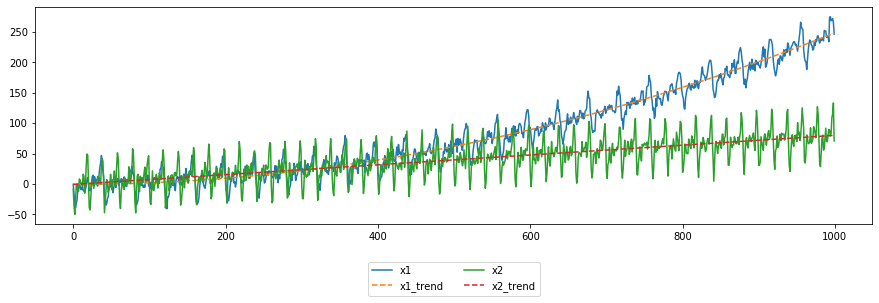

In [7]:
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')

plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

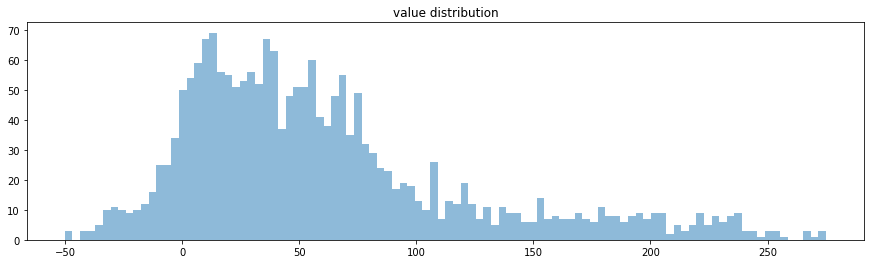

In [8]:
plt.figure(figsize=(15, 4))
plt.hist(np.column_stack([x1, x2]).flatten(), bins=100, alpha=0.5)
plt.title('value distribution')
plt.show()

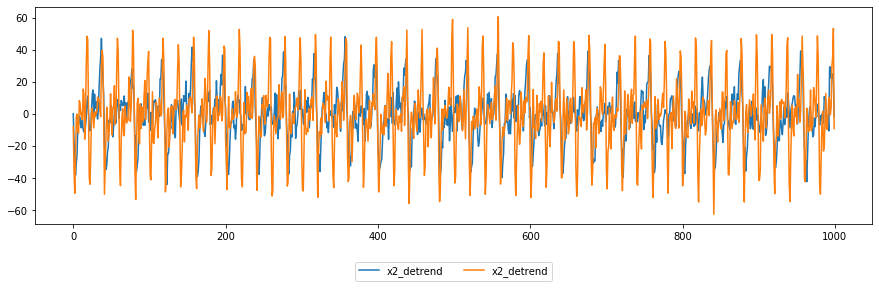

In [9]:
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend

plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### Split

In [10]:
train_ratio = 0.8
train_len = int(train_ratio*x_index.shape[0])
print(train_len)

800


In [11]:
# x_lbl columns: ===================
# columns1: detrended x1, 
# columns2: detrended x2, 
# columns3: index
# columns4: 1 for train set, 0 for test set

x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(1000, 4)
[[ 2.26891927e-01 -7.90016128e+00  0.00000000e+00  1.00000000e+00]
 [-1.63346447e+01 -3.54582824e+01  1.00000000e+00  1.00000000e+00]
 [-2.71900539e+01 -4.94295916e+01  2.00000000e+00  1.00000000e+00]
 ...
 [ 2.49630752e+01  3.51525930e+01  9.97000000e+02  0.00000000e+00]
 [ 1.79196638e+01  5.33812005e+01  9.98000000e+02  0.00000000e+00]
 [-1.68066974e+00 -9.08650401e+00  9.99000000e+02  0.00000000e+00]]


### Normalize

In [12]:
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

[48.264220246984586, 60.682815050181624, 1, 1]


In [13]:
# x_lbl columns: ===================
# columns1: normalized detrended x1, 
# columns2: normalized detrended x2, 
# columns3: index
# columns4: 1 for train set, 0 for test set

x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

[[ 4.70103786e-03 -1.30187785e-01  0.00000000e+00  1.00000000e+00]
 [-3.38442113e-01 -5.84321646e-01  1.00000000e+00  1.00000000e+00]
 [-5.63358401e-01 -8.14556667e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 5.17217001e-01  5.79284151e-01  9.97000000e+02  0.00000000e+00]
 [ 3.71282572e-01  8.79675745e-01  9.98000000e+02  0.00000000e+00]
 [-3.48222707e-02 -1.49737681e-01  9.99000000e+02  0.00000000e+00]]


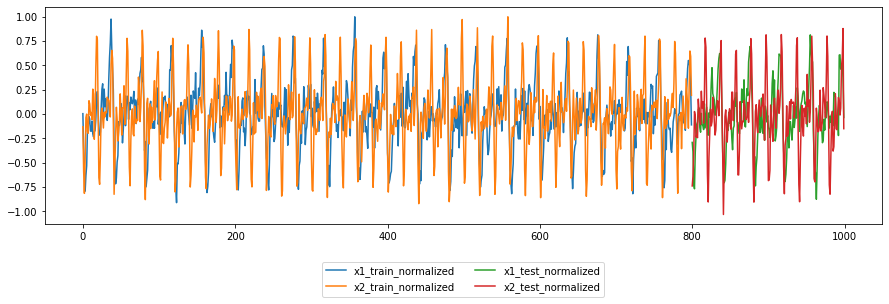

In [14]:
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### Truncate

In [15]:
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
    

In [16]:
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 3) (781, 20, 3) (781,)


In [17]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]

X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]

print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


# Model
![Image of Luong Attention](https://github.com/HuangWeiKulish/Forecasting/blob/master/seq2seq.png?raw=true)

In [18]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [19]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
n_hidden = 100
print(input_train)
print(output_train)

Tensor("input_1:0", shape=(None, 200, 2), dtype=float32)
Tensor("input_2:0", shape=(None, 20, 2), dtype=float32)


#### What to Return using LSTM
- __*return_sequences=False, return_state=False*__: the last hidden state: state_h
- __*return_sequences=True, return_state=False*__: return stacked hidden states (num_timesteps * num_cells): one hidden state output for each input time step
- __*return_sequences=False, return_state=True*__: generate 3 arrays: state_h, state_h, state_c
- __*return_sequences=True, return_state=True*__: generate 3 arrays: stacked hidden states, last state_h, last state_c

In [20]:
encoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
               return_state=False, return_sequences=False)(input_train)
display(encoder)

<tf.Tensor 'lstm_1/strided_slice_18:0' shape=(None, 100) dtype=float32>

In [21]:
encoder = BatchNormalization(momentum=0.6)(encoder) 
display(encoder)

<tf.Tensor 'batch_normalization_1/cond/Identity:0' shape=(None, 100) dtype=float32>

In [22]:
decoder = RepeatVector(output_train.shape[1])(encoder)
display(decoder)

<tf.Tensor 'repeat_vector_1/Tile:0' shape=(None, 20, 100) dtype=float32>

In [23]:
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
               return_state=False, return_sequences=True)(decoder)
display(decoder)

<tf.Tensor 'lstm_2/transpose_1:0' shape=(None, 20, 100) dtype=float32>

In [24]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
display(out)

<tf.Tensor 'time_distributed_1/Reshape_1:0' shape=(None, 20, 2) dtype=float32>

In [25]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 2)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               41200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 100)           80400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 2)             202       
Total params: 122,202
Trainable params: 122,002
Non-trainable params: 200
___________________________________________________

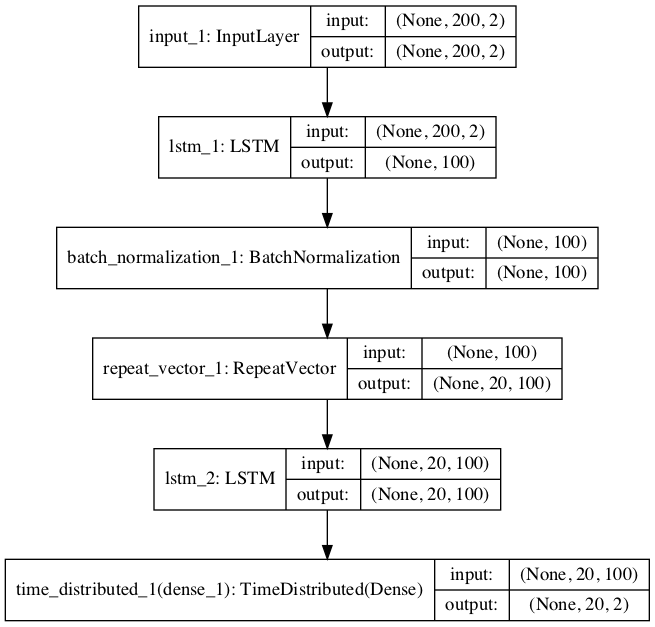

In [26]:
from keras.utils.vis_utils import plot_model
import pydot as pyd
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pyd

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [27]:
epc = 110
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

model.save('model_forecasting_demo.h5')

Train on 480 samples, validate on 120 samples
Epoch 1/110
480/480 [==============================] - 3s 6ms/step - loss: 1.9348 - mae: 0.7702 - val_loss: 0.1126 - val_mae: 0.2541
Epoch 2/110
480/480 [==============================] - 2s 4ms/step - loss: 0.1773 - mae: 0.3229 - val_loss: 0.1067 - val_mae: 0.2417
Epoch 3/110
480/480 [==============================] - 2s 5ms/step - loss: 0.1306 - mae: 0.2719 - val_loss: 0.1083 - val_mae: 0.2491
Epoch 4/110
480/480 [==============================] - 2s 5ms/step - loss: 0.1213 - mae: 0.2592 - val_loss: 0.1043 - val_mae: 0.2399
Epoch 5/110
480/480 [==============================] - 2s 5ms/step - loss: 0.1188 - mae: 0.2545 - val_loss: 0.1029 - val_mae: 0.2359
Epoch 6/110
480/480 [==============================] - 2s 4ms/step - loss: 0.1170 - mae: 0.2519 - val_loss: 0.1024 - val_mae: 0.2365
Epoch 7/110
480/480 [==============================] - 2s 4ms/step - loss: 0.1156 - mae: 0.2506 - val_loss: 0.1026 - val_mae: 0.2365
Epoch 8/110
480/480 [==

Epoch 62/110
480/480 [==============================] - 2s 4ms/step - loss: 0.0468 - mae: 0.1630 - val_loss: 0.0266 - val_mae: 0.1282
Epoch 63/110
480/480 [==============================] - 2s 4ms/step - loss: 0.0463 - mae: 0.1611 - val_loss: 0.0266 - val_mae: 0.1274
Epoch 64/110
480/480 [==============================] - 2s 3ms/step - loss: 0.0522 - mae: 0.1689 - val_loss: 0.0374 - val_mae: 0.1460
Epoch 65/110
480/480 [==============================] - 2s 4ms/step - loss: 0.0511 - mae: 0.1696 - val_loss: 0.0317 - val_mae: 0.1406
Epoch 66/110
480/480 [==============================] - 2s 4ms/step - loss: 0.0503 - mae: 0.1682 - val_loss: 0.0274 - val_mae: 0.1310
Epoch 67/110
480/480 [==============================] - 2s 4ms/step - loss: 0.0429 - mae: 0.1554 - val_loss: 0.0232 - val_mae: 0.1210
Epoch 68/110
480/480 [==============================] - 2s 4ms/step - loss: 0.0453 - mae: 0.1585 - val_loss: 0.0295 - val_mae: 0.1299
Epoch 69/110
480/480 [==============================] - 2s 4ms

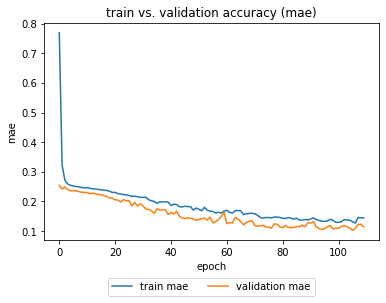

In [28]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# Predict

In [29]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


In [30]:
# combine with the index
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


In [31]:
# recover trend
data_final = dict()

for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))


train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


In [32]:
for k in ['train_pred', 'train_true', 'test_pred', 'test_true']:
    print('maximum: {}'.format(k))
    print(data_final[k].max())

maximum: train_pred
186.43868688993894
maximum: train_true
183.4735467506097
maximum: test_pred
275.8361148622688
maximum: test_true
274.8642467295481


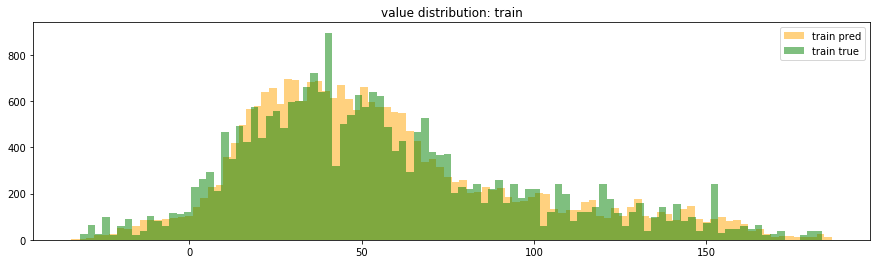

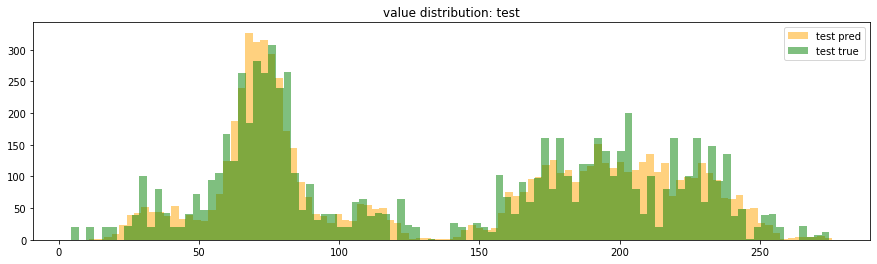

In [33]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

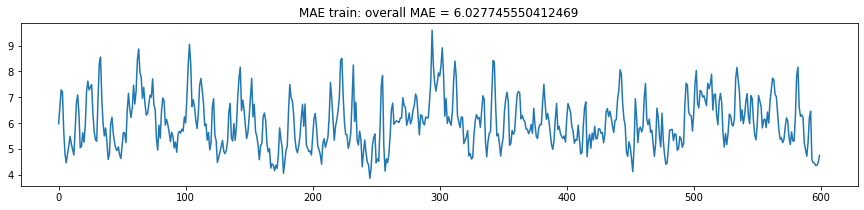

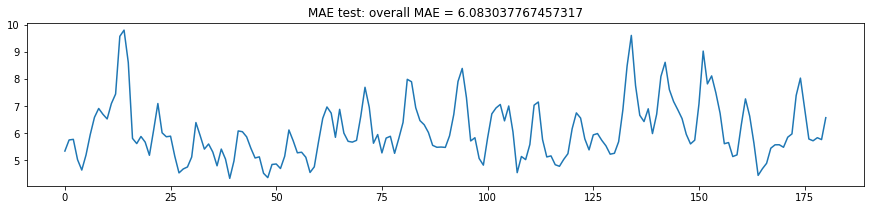

In [34]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show() 

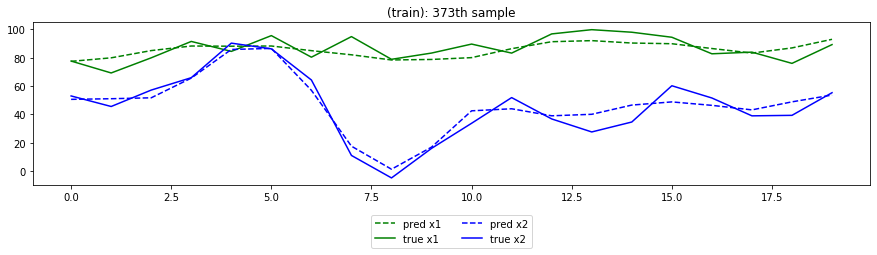

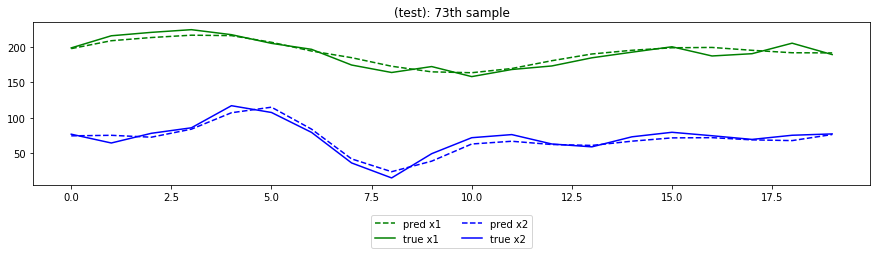

In [35]:
for lb in ['train', 'test']:
    ith_sample = random.choice(range(data_final[lb+'_pred'].shape[0]))

    plt.figure(figsize=(15,3))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][ith_sample, :, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][ith_sample, :, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th sample'.format(lb, ith_sample))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()


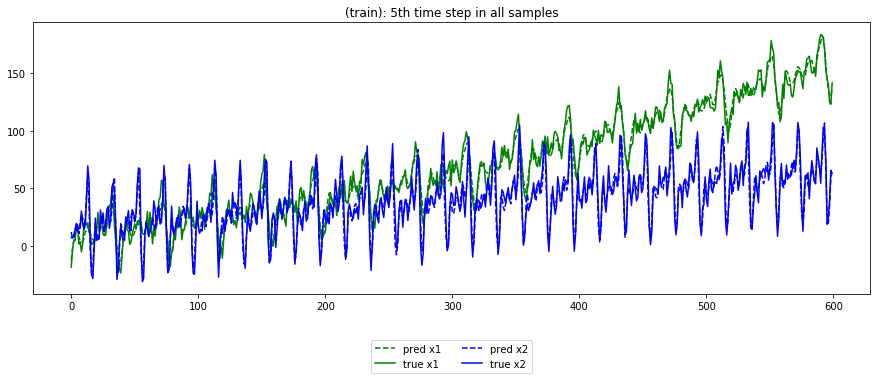

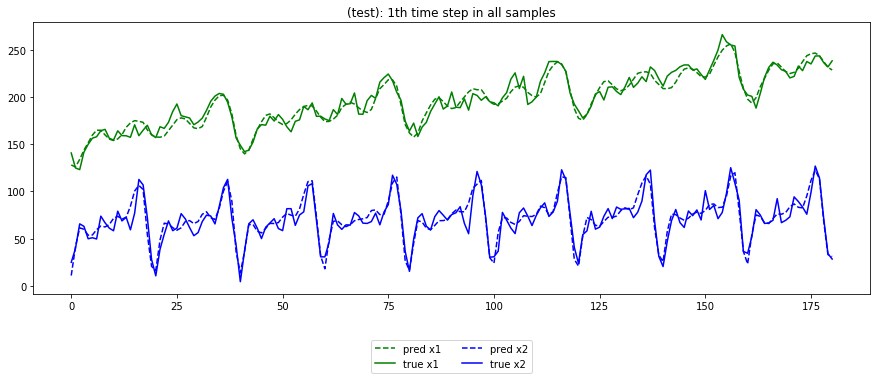

In [36]:
for lb in ['train', 'test']:
    ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
    plt.figure(figsize=(15, 5))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()
